# The Oxford-IIIT Pet Dataset
- https://www.robots.ox.ac.uk/~vgg/data/pets/
- 37개 카테고리의 개, 고양이 품종 데이터셋. 각 클래스 별로 대략 200여장의 이미지를 제공한다.
- 파일명에 품종이 포함되어 있어 classification 데이터셋을 만들 수 있다.
- 3686개 이미지에대한 annotation 파일을 제공한다.
    - bounding box는 각 pet의 얼굴을 가리킨다.
- 한계: 하나의 물체만 담긴 사진뿐이다.

In [ ]:
# library import
import os
 
import re
import random
import xml.etree.ElementTree as et
from PIL import Image
 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
 
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


# Oxford Pet Dataset
- 파일명
    - 품종명_번호.jpg
    - 대문자로 시작: 고양이, 소문자로 시작: 개
    - Egyptian_Mau_1.jpg, american_bulldog_10.jpg

### 데이터셋 다운로드

In [ ]:
!pip install gdown

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1gXqmWrxJqdp_luNKZmv81vY5cjFLuTdT'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gXqmWrxJqdp_luNKZmv81vY5cjFLuTdT
To: /content/oxford_pet.zip
811MB [00:03, 235MB/s]


'oxford_pet.zip'

In [ ]:
# !rm -r oxford_pet # 압축 이후 상황에서 압축 파일 제거 명령

In [ ]:
## 압축풀기
# unzip 압축파일 -d 압축을 풀 디렉토리
!unzip -q oxford_pet.zip -d oxford_pet

replace oxford_pet/annotations/._trimaps? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [ ]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images  tfrecord


In [ ]:
# 경로 설정
base_dir = '/content/oxford_pet' #데이터셋 기본경로
image_dir = os.path.join(base_dir, 'images') # image 디렉토리 경로
bbox_dir = os.path.join(base_dir, 'annotations', 'xmls') #annotation 파일경로
print(base_dir, image_dir, bbox_dir)

/content/oxford_pet /content/oxford_pet/images /content/oxford_pet/annotations/xmls


In [ ]:
os.listdir(image_dir)

['german_shorthaired_109.jpg',
 'leonberger_110.jpg',
 'Russian_Blue_20.jpg',
 'pug_73.jpg',
 'keeshond_196.jpg',
 'english_setter_178.jpg',
 'Egyptian_Mau_14.jpg',
 'Ragdoll_261.jpg',
 'Sphynx_206.jpg',
 'great_pyrenees_162.jpg',
 'Ragdoll_57.jpg',
 'english_cocker_spaniel_26.jpg',
 'Egyptian_Mau_129.jpg',
 'shiba_inu_144.jpg',
 'pomeranian_36.jpg',
 'english_setter_32.jpg',
 'miniature_pinscher_145.jpg',
 'leonberger_181.jpg',
 'Ragdoll_122.jpg',
 'Abyssinian_97.jpg',
 'Abyssinian_108.jpg',
 'Bengal_162.jpg',
 'Bombay_34.jpg',
 'miniature_pinscher_64.jpg',
 'shiba_inu_174.jpg',
 'Ragdoll_80.jpg',
 'newfoundland_23.jpg',
 'pug_156.jpg',
 'havanese_10.jpg',
 'British_Shorthair_46.jpg',
 'japanese_chin_132.jpg',
 'basset_hound_44.jpg',
 'chihuahua_193.jpg',
 'saint_bernard_170.jpg',
 'Bombay_79.jpg',
 'german_shorthaired_43.jpg',
 'Sphynx_153.jpg',
 'Bombay_1.jpg',
 'japanese_chin_185.jpg',
 'Persian_187.jpg',
 'havanese_74.jpg',
 'shiba_inu_10.jpg',
 'Siamese_203.jpg',
 'basset_hound_8

In [ ]:
# 이미지 파일명 조회
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']  # jpg파일명만 리스트로 생성
print(len(image_files))
 
image_files[:3]

7390


['german_shorthaired_109.jpg', 'leonberger_110.jpg', 'Russian_Blue_20.jpg']

In [ ]:
#annotation 파일 경로
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']  # xml파일명만 리스트로 생성
print(len(bbox_files))

bbox_files[:3]

3686


['boxer_178.xml', 'saint_bernard_123.xml', 'english_setter_142.xml']

In [ ]:
# 이미지 파일중 RGB가 아닌 이미지 파일과 그 파일에 대한 annotation파일 제거
remove_image_cnt = 0
for image_file in image_files:
    # 이미지 파일과 그에 매핑되는 annotation 파일 경로 조회
    image_path = os.path.join(image_dir, image_file)
    bbox_file = os.path.splitext(image_file)[0]+'.xml'
    bbox_path = os.path.join(bbox_dir, bbox_file)
    
    image = Image.open(image_path) # 이미지파일 읽기
    image_mode = image.mode # 이미지 색공간을 string으로 반환
    if image_mode != 'RGB': # RGB가 아니면 파일 삭제
        image = np.asarray(image)
        print(image_file, image_mode, image.shape)

        os.remove(image_path) # 파일 삭제
        remove_image_cnt += 1
        try:
            os.remove(bbox_path) # xml annotation 파일이 없는 경우 remove()에서 발생하는 예외 처리
            print(bbox_path)
        except FileNotFoundError:
            pass

Egyptian_Mau_14.jpg RGBA (800, 582, 4)
Egyptian_Mau_129.jpg L (325, 299)
/content/oxford_pet/annotations/xmls/Egyptian_Mau_129.xml
Egyptian_Mau_145.jpg P (188, 216)
Abyssinian_5.jpg RGBA (150, 200, 4)
Egyptian_Mau_167.jpg P (275, 183)
staffordshire_bull_terrier_2.jpg L (282, 500)
Egyptian_Mau_177.jpg P (175, 246)
Egyptian_Mau_191.jpg P (214, 300)
Abyssinian_34.jpg P (202, 250)
staffordshire_bull_terrier_22.jpg L (500, 364)
Egyptian_Mau_186.jpg RGBA (275, 183, 4)
Egyptian_Mau_139.jpg P (250, 350)


In [ ]:
remove_image_cnt

12

In [ ]:
# 삭제후 image, annotation 파일 목록 다시만들기
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']

In [ ]:
len(image_files), len(bbox_files)

(7378, 3685)

### class dictionary 생성

In [ ]:
# class_name = ['진돗개', '치와와']

In [ ]:
# 클래스 딕셔너리 리스트로 만들기
class_list = set() 
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0] # 파일명 추출 # Egyptian_Mau_139,   .jpg
    class_name = re.sub('_\d+', '', file_name)  # 품종_숫자 => _숫자 제거
    class_list.add(class_name)    
class_list = list(class_list) # set->list
class_list.sort()   # 정렬
print(len(class_list))

37


In [ ]:
class_list[:5], class_list[-5:]

(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair'],
 ['scottish_terrier',
  'shiba_inu',
  'staffordshire_bull_terrier',
  'wheaten_terrier',
  'yorkshire_terrier'])

In [ ]:
predict_result = 3
class_list[3]

'Bombay'

In [ ]:
# 리스트 딕셔너리로 만들기: class->index로 반환하는 것.
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [ ]:
class2idx['Bombay'] # => 3

3

# train/validation 데이터셋 만들기

## TFRecord 만들기

In [ ]:
IMG_SIZE = 224 # resize 크기
N_BBOX = len(bbox_files) # annotation 파일이 있는 데이터셋만 사용 => 전체 데이터 개수
N_TRAIN = 3000 # train set의 개수
N_VAL = N_BBOX - N_TRAIN # validation set의 개수

In [ ]:
## TFRecord 저장할 directory 생성
tfr_dir = os.path.join(base_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'oxford_train.tfr') # train set을 저장할 tfrecord
tfr_val_dir = os.path.join(tfr_dir, 'oxford_val.tfr') # test set을 저장할 tfrecord

In [ ]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [ ]:
# The following functions can be used to convert a value to a type compatible with tf.Example.
 # 값을 Feature로 변환하는 함수
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
 
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
 
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
# train, validation 데이터셋의 index 설정

# 데이터 섞기
shuffle_list = list(range(N_BBOX)) 
random.shuffle(shuffle_list) 
# 분할
train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [ ]:
# Train TFRecord 생성
for idx in train_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
    # annotation(root태그) - size - width, height
    # annotation - object - bndbox - xmin, ymin, xmax, ymax
    tree = et.parse(bbox_path) # 이때 현재 위치: xml파일경로(tree위치, root태그)
    width = float(tree.find('./size/width').text) # .text - 태그 내 내용을 문자열(string)으로 반환
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    #X, Y Center 좌표
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.

    x = xc / width
    y = yc / height

    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    # 이미지 파일
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg' # 이미지 파일명
    image_path = os.path.join(image_dir, image_file) # 이미지경로+이미지파일명 => 이미지 경로
    image = Image.open(image_path) # 이미지 파일 읽기
    image = image.resize((IMG_SIZE, IMG_SIZE)) # (244,244)로 resize
    bimage = image.tobytes() # 이미지를 bytes 타입으로 변환

    # 품종 라벨 => LabelEncoding
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
    
    # 개/고양이(이진분류) 라벨 => LabelEncoding (개-소문자시작:0, 고양이-대문자시작:1)
    if file_name[0].islower():
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    # Example: 데이터 1개 => 여러개 Feature들
    example = tf.train.Example(features=tf.train.Features(feature={
          'image': _bytes_feature(bimage),          # 이미지 파일
          'cls_num': _int64_feature(class_num),     # 라벨 - 품종 라벳(정수로 변환된 - 0 ~ 36)
          'bi_cls_num': _int64_feature(bi_cls_num), # 라벨 - 개/고양이(정수로 변환된 - 0:고양이/1:개)
          'x': _float_feature(x),  # bbox의 center x좌표
          'y': _float_feature(y),  # bbox의 center y좌표
          'w': _float_feature(w),  # bbox의 center width(너비)
          'h': _float_feature(h)   # bbox의 center height(높이)
    }))
    writer_train.write(example.SerializeToString()) # tfrecord 파일에 출력

writer_train.close()

In [1]:
# Validation TFRecord 생성
for idx in val_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
 
    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('.size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]

    if file_name[0].islower():
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    
    example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
    }))
    writer_val.write(example.SerializeToString())

writer_val.close()

NameError: name 'val_idx_list' is not defined

# Localization 모델 학습

In [ ]:
## Hyper Parameters
LEARNING_RATE = 0.0001
N_CLASS = len(class_list)
N_EPOCHS = 40
N_BATCH = 40
IMG_SIZE = 224

steps_per_epoch = N_TRAIN // N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH)) 

print(steps_per_epoch, validation_steps)

75 18


In [ ]:
# TFRecord에 저장된 Dataset의 하나의 Data를 parsing하는 함수
def _parse_function(tfrecord_serialized):
    """
    [매개변수]
        tfrecord_serialized: parsing할 1개의 data
    [반환값] 
        튜플 (image, ground truth)
    """
    
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)  # feature(이미지 bytes) => image data(Tensor)로 변환
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3]) # input_shape의 형태로 reshape
    image = tf.cast(image, tf.float32)/255.
    
    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    grount_truth = tf.stack([x, y, w, h], -1)
    
    return image, grount_truth # X, y - X: image, y(output): x,y,w,h - localization만 할 예정이므로 bbox의 위치만 변화

In [ ]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
# num_parallel_calls: 병렬처리를 이용해 변환 속도를 높이는 역할
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()
# prefetch(tf.data.experimental.AUTOTUNE) : 현재 배치 처리하면서 다음 배치를 미리 읽어오는 작업 지시

In [ ]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

### Trainset의 데이터 읽어서 bounding box 확인

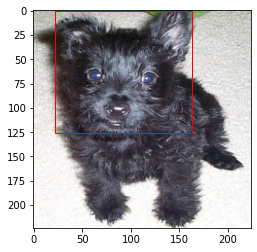

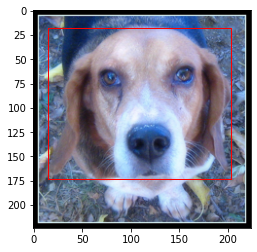

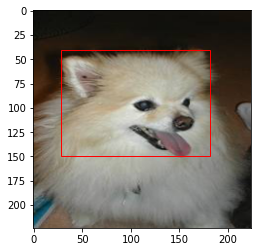

In [ ]:
# _parse_function() 반환값 : image, ground_truth(x,y,w,h)
for image, gt in val_dataset.take(3): # 반복 3번 - 한번 반복 시 N번째 배치값을 조회
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0] 
    y = gt[:,1] 
    w = gt[:,2] 
    h = gt[:,3] 
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    # 조회된 xmin, ymin, w, h는 0 ~ 1로 normalize된 값(이미지의 width, height에 대한 비율)
    #  => 원래 크기(값)으로 복원. x,w는 이미지 width 곱하고, y,h는 이미지 height를 곱한다.
    #     (이미지를 224x224로 resize했으므로 IMG_SIZE(224)를 곱한다.)
    rect_x = int(xmin * IMG_SIZE) 
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    # Rectangle( (xmin, ymin), box width, box_height, fill=색을채울지여부, color=선색)
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

## 모델 생성 및 학습


In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [ ]:
def create_l_model():
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model = keras.models.Sequential()
    model.add(resnet101v2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(ReLU())

    # 출력 layer(x,y,w,h) => unit을 4. 각각 출력값이 0 ~ 1 사이의 값으로 normalize 되었으므로 출력결과도 해당 scale에 맞추기 위해 sigmoid 활성함수 사용
    # localization문제 (위치-좌표, 너비, 높이 예측) =>  회귀(Regression문제)
    model.add(Dense(4, activation='sigmoid'))
    return model

In [ ]:
model = create_l_model()
model.summary()

171319296/171317808 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_______________________________________________________

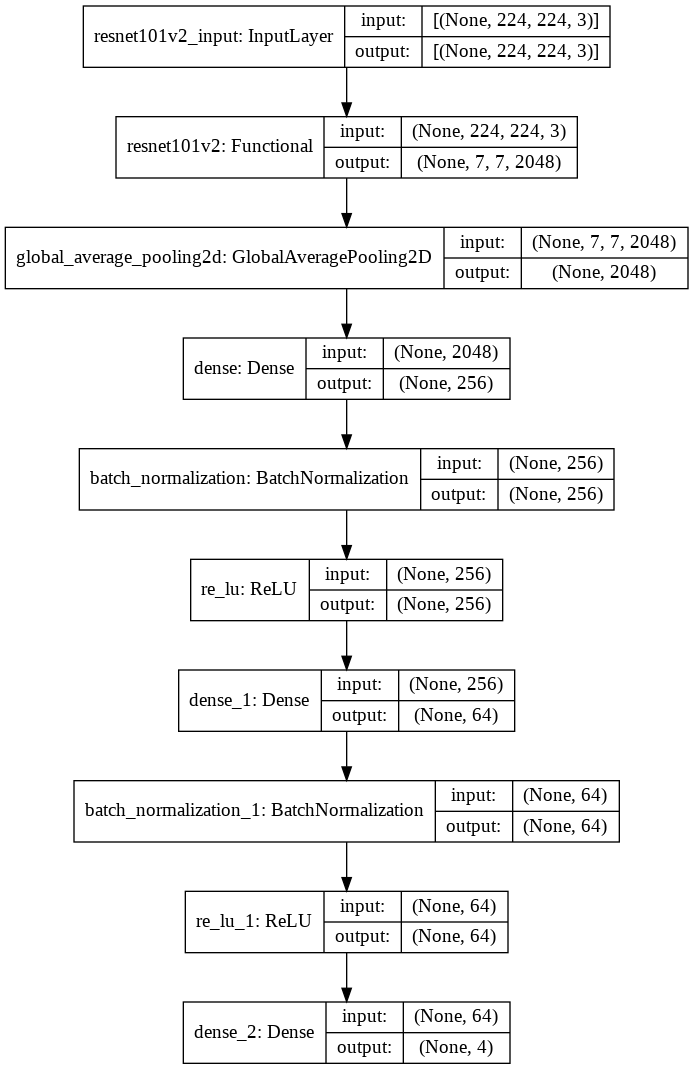

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# 모델 컴파일
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE, # 초기 learning_rate: 0.0001
                                                          decay_steps=steps_per_epoch*10,      # 몇 step당 learning_rate를 변경 (10 에폭)
                                                          decay_rate=0.5,                      # 변경할 learning_rate의 비율 (현재 learning_rate * decay_rate)
                                                          staircase=True)                      # step마다 조금씩 변경할지 여부
model.compile(optimizers.Adam(lr_schedule), loss="mse") # 회귀 문제이므로 Mean Squared Error를 loss함수로 지정

In [ ]:
N_EPOCHS = 2 # 학습 시간 조정을 위한 임시 에폭 수

filepath = r'/content/drive/MyDrive/save_models/oxford_pet_localization_resnet101v2_model'
# val_loss의 성능이 가장 좋았던 상태의 모델 저장
mc_callback = keras.callbacks.ModelCheckpoint(filepath, 'val_loss',verbose=1, save_best_only=True)
# val_loss가 5번의 에폭동안 개선되지 않으면 중간에 학습 중단
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    epochs=N_EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps, 
                    callbacks=[mc_callback, es_callback])

Epoch 1/2
75/75 [==============================] - 95s 687ms/step - loss: 0.0460 - val_loss: 0.0344

Epoch 00001: val_loss improved from inf to 0.03440, saving model to /content/drive/MyDrive/save_models/oxford_pet_localization_resnet101v2_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/save_models/oxford_pet_localization_resnet101v2_model/assets
Epoch 2/2
75/75 [==============================] - 59s 694ms/step - loss: 0.0141 - val_loss: 0.0159

Epoch 00002: val_loss improved from 0.03440 to 0.01590, saving model to /content/drive/MyDrive/save_models/oxford_pet_localization_resnet101v2_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/save_models/oxford_pet_localization_resnet101v2_model/assets


In [ ]:
!nvidia-smi

Wed May 12 04:42:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   9026MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 확인

In [ ]:
# 미리학습한 모델 다운로드
import gdown
url = 'https://drive.google.com/uc?id=1-2IbiHp3SdffxkqIj4iGL9-recS6g697'
fname = 'oxford_pet_localization_resnet101.tar.gz'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-2IbiHp3SdffxkqIj4iGL9-recS6g697
To: /content/oxford_pet_localization_resnet101.tar.gz
475MB [00:02, 161MB/s]


'oxford_pet_localization_resnet101.tar.gz'

In [ ]:
!mkdir models

In [ ]:
# -옵션 -z: .gz확장자 파일 압축해제, -v: tar압축파일 압축해제, -C: 압축해제 디렉토리 설정(default: 현재 디렉토리)
!tar -zxvf oxford_pet_localization_resnet101.tar.gz -C  models

oxford_pet_localization_resnet101v2_model/
oxford_pet_localization_resnet101v2_model/variables/
oxford_pet_localization_resnet101v2_model/variables/variables.index
oxford_pet_localization_resnet101v2_model/variables/variables.data-00000-of-00001
oxford_pet_localization_resnet101v2_model/assets/
oxford_pet_localization_resnet101v2_model/saved_model.pb


In [ ]:
# 저장된 모델 load
filepath = '/content/models/oxford_pet_localization_resnet101v2_model'
saved_model = keras.models.load_model(filepath)

In [ ]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

### Bounding Box 그리기

In [ ]:
validation_steps

18

In [ ]:
# 예측한 bounding box와 ground truth box를 image에 같이 표시
# 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):

    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]

    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.

    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)    

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    prediction = saved_model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    plt.imshow(val_data[idx])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### IoU확인하기

In [ ]:
## Valiation set의 IOU 계산
avg_iou = 0
num_imgs = validation_steps
# N_VAL: validation data 개수 % batch_size =>  마지막 배치의 데이터 개수
res = N_VAL % N_BATCH
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):

    # flag: True - 마지막 배치의 데이터 ioU처리, False - 중간 배치들 데이터에 대한 IoU처리
    flag = (i == validation_steps-1) # i: 현재 반복횟수 - 몇번쨰 배치에 대한 처리

    # ground_truth의 x,y,w,h 조합
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    # predict
    prediction = saved_model.predict(val_data)
    # 예측 결과: x,y,w,h
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_BATCH):
        if flag:  # True: 마지막 배치 처리
            if idx == res:  # True: 마지막 배치의 모든 데이터
                flag = False
                break

        # 1개 이미지에 대한 IoU값 계산
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        # 두 개 box가 겹치지 않은 경우
        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        
        gt_width = xmax - xmin
        gt_height = ymax - ymin
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin

        # 교집합 영역의 width, height 구하기
        inter_width  =  np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        inter_height = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

        iou = (inter_width * inter_height)/((gt_width * gt_height) + (pred_width * pred_height) - (inter_width * inter_height))

        avg_iou += iou / N_VAL

print(avg_iou)

0.7617100977604425


# Classification을 추가하여 Multi-task Learning으로 Localization 학습하기

- **고양이/개 2개 class로 classification**

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [ ]:
#tfrecord 파싱 함수(classification + localization)
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.float32)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.float32)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    ground_truth = tf.stack([bi_cls_label, x, y, w, h], -1) 
    
    return image, ground_truth

In [ ]:
#Train Dataset 생성
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [ ]:
#Validation Dataset 생성
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [ ]:
def create_cl_model():    
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    gap = GlobalAveragePooling2D()(resnet101v2.output)

    dense_b1_1 = Dense(256)(gap)
    bn_b1_2 = BatchNormalization()(dense_b1_1)
    relu_b1_3 = ReLU()(bn_b1_2)
    dense_b1_4 = Dense(64)(relu_b1_3)
    bn_b1_5 = BatchNormalization()(dense_b1_4)
    relu_b1_6 = ReLU()(bn_b1_5)
    # classification 출력 (2진분류 -> 다중분류, 결과: dog확률, cat확률)
    output1 = Dense(2, activation='softmax', name='output1')(relu_b1_6)

    dense_b2_1 = Dense(256)(gap)
    bn_b2_2 = BatchNormalization()(dense_b2_1)
    relu_b2_3 = ReLU()(bn_b2_2)
    dense_b2_4 = Dense(64)(relu_b2_3)
    bn_b2_5 = BatchNormalization()(dense_b2_4)
    relu_b2_6 = ReLU()(bn_b2_5)
    # localization의 출력. 좌표 0 ~ 1 normalization되어있으므로 scale을 맞추기 위해 sigmoid 사용
    output2 = Dense(4, activation='sigmoid', name='output2')(relu_b2_6)
    
    concat = Concatenate(name='finaly_output')([output1, output2])
    return keras.Model(inputs=resnet101v2.input, outputs=concat)

In [ ]:
model = create_cl_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Loss 함수 구현
def loss_fn(y_true, y_pred):
    """
    [매개변수]
        y_true: ndarray - ground truth(정답),
        y_pred: ndarray - 모델이 예측한 결과
    [반환값]
        실수(float) - y_true와 y_pred 사이의 오차
    """
    cls_labels = tf.cast(y_true[:,:1], tf.int64) # Ground Truth의 분류관련 y값 (index 0) => one hot encoding 미처리 상태
    loc_labels = y_true[:,1:] # Ground Truth의 x,y,w,h 좌표

    cls_preds = y_pred[:,:2] # 예측결과 중 분류관련 y값
    loc_preds = y_pred[:,2:] # 예측결과 중 좌표
    cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds)
    loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)
    return cls_loss + 5*loc_loss # 두 loss를 더해서 반환 (한쪽 loss에 가중치(중요도)를 주고 싶은 경우 해당 loss의 가중치 늘려서 더하여 전달)

In [ ]:
# 모델 컴파일
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizers.Adam(lr_schedule), loss=loss_fn)

In [ ]:
# 학습
filepath2 = r'/content/drive/MyDrive/save_models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt'
mc_callback = keras.callbacks.ModelCheckpoint(filepath2, 'val_loss',verbose=1, save_best_only=True, save_weights_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

N_EPOCHS = 1 # 임시 에폭수
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    epochs=N_EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[mc_callback, es_callback])

75/75 [==============================] - 96s 668ms/step - loss: 0.6322 - val_loss: 0.3358

Epoch 00001: val_loss improved from inf to 0.33576, saving model to /content/drive/MyDrive/save_models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt


# 확인

### 미리 학습된 weights 가져오기 평가하기

In [ ]:
# 미리학습한 모델 다운로드
import gdown
url = 'https://drive.google.com/uc?id=1ycRNri9Gr6QjcOFv4GQi_DLCU17JbOyo'
fname = 'oxford_pet_classification_localization_resnet101_weight.tar.gz'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ycRNri9Gr6QjcOFv4GQi_DLCU17JbOyo
To: /content/oxford_pet_classification_localization_resnet101_weight.tar.gz
481MB [00:02, 235MB/s]


'oxford_pet_classification_localization_resnet101_weight.tar.gz'

In [ ]:
!mkdir models

In [ ]:
# 압축풀기
!tar -zxvf oxford_pet_classification_localization_resnet101_weight.tar.gz -C  models

oxford_pet_localization_classification_resnet101v2_weights/
oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt.index
oxford_pet_localization_classification_resnet101v2_weights/checkpoint
oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt.data-00000-of-00001


In [ ]:
# 마지막으로 저장된 checkpoint 경로 확인
best_weight_path = tf.train.latest_checkpoint('/content/models/oxford_pet_localization_classification_resnet101v2_weights')
best_weight_path

'/content/models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt'

In [ ]:
# 저장된 weight load 
saved_model2 = create_cl_model()
saved_model2.load_weights(best_weight_path)

### Bounding Box 확인

In [ ]:
# 배치중 idx번째 것만 확인
idx = 1
num_imgs = validation_steps 
for val_data, val_gt in val_dataset.take(num_imgs):
    
    gt_cls_name = np.where(val_gt[:,0]==0,'dog','cat')
    
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)    
    
    prediction = saved_model2.predict(val_data)
    
    pred_cls_idx = np.argmax(prediction[:,:2], axis=-1)
    pred_cls_name = np.where(pred_cls_idx==0, 'dog','cat')
    
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    plt.title(f'Ground Truth-{gt_cls_name[idx]}, Pred:{pred_cls_name[idx]}')
    
    plt.imshow(val_data[idx])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### IoU 계산

In [ ]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):    
    flag = (i == validation_steps-1)
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]

    prediction = saved_model2.predict(val_data)
    
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    for idx in range(N_BATCH):
        if(flag):
            if idx == res:
                flag = False
                break          
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        
        gt_width = xmax-xmin
        gt_height = ymax - ymin
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin

        inter_width  =  np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        inter_height = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))


        iou = (inter_width * inter_height)/((gt_width * gt_height) + (pred_width * pred_height) - (inter_width * inter_height))
        avg_iou += iou / N_VAL
        
print(avg_iou)

0.8277095223793521


# 새로운 Image로 Test하기

In [ ]:
from PIL import Image
image = Image.open('cat.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.
image = image[np.newaxis, ...]
print(image.shape)

(1, 224, 224, 3)


cat


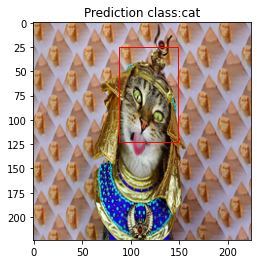

In [ ]:
# 예측 결과 확인 - bounding box, class
from matplotlib.patches import Rectangle
prediction = saved_model2.predict(image)
pred_cls = np.where(np.argmax(prediction[0,:2], axis=-1)==0, 'dog', 'cat')
print(pred_cls)
pred_x = prediction[0,2]
pred_y = prediction[0,3]
pred_w = prediction[0,4]
pred_h = prediction[0,5]
pred_xmin = pred_x - pred_w/2.
pred_ymin = pred_y - pred_h/2.
pred_rect_x = int(pred_xmin * IMG_SIZE)
pred_rect_y = int(pred_ymin * IMG_SIZE)
pred_rect_w = int(pred_w * IMG_SIZE)
pred_rect_h = int(pred_h * IMG_SIZE)

pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                       fill=False, color='red')
plt.axes().add_patch(pred_rect)

import matplotlib.pyplot as plt
plt.imshow(image[0])
plt.title(f'Prediction class:{pred_cls}')
plt.show()